In [15]:
from torch.utils.data import Dataset, DataLoader
from Crawling_Dataset import Crawling_Nomal_Dataset
import torch
import cv2 
import os
import numpy as np
from torchvision import transforms
import torch.utils.data as data
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
import math
import tqdm as tqdm
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from torchvision.transforms import Resize
# from cheff import bring

In [16]:
test_path = '/opt/ml/project/data/celeb/cut_test'
train_path = '/opt/ml/project/data/celeb/cut_train'

In [17]:
transform = transforms.Compose([
        np.float32,
        transforms.ToTensor(),  # range [0, 255] -> [0.0, 1.0]
        # Resize((112, 112)),
        Resize((160, 160)),
        fixed_image_standardization
    ])

In [18]:
test_dataset = Crawling_Nomal_Dataset(test_path, transforms=transform)
train_dataset = Crawling_Nomal_Dataset(train_path, transforms=transform)
test_data_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)
train_data_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)

In [19]:
def get_label_per_path_dict(data_loader) :
    identities = defaultdict(lambda : list())
    # dict = {label1 : [image_path_1.jpg,image_path_2.jpg,....],
    #        label2 : [image_path_1.jpg,image_path_2.jpg,....],...}
    
    for img,  path_label in data_loader :
        img_path = path_label[0][0]
        img_label = path_label[1].tolist()[0]
        # print(img_path, img_label, sep='\n')
        identities[img_label].append(img_path)
    return identities

In [20]:
identities = get_label_per_path_dict(test_data_loader)

/opt/conda/envs/deepface/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/envs/deepface/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in orde

In [21]:
from backbones import get_model
# from backbones import IResNet, IBasicBlock, get_model
# from backbones.Inception_resnet import InceptionResnetV1
import pandas as pd

In [22]:
# backbone = get_model(
#     cfg.network, dropout=0.0, fp16=cfg.fp16, num_features=cfg.embedding_size).cuda()


# model = get_model('r50',False)
# model = get_model('r50', fp16=False, num_features=512).cuda() # dropout=0.0
model = get_model('ghost', fp16=False, num_features=512).cuda() # dropout=0.0

In [23]:
model_pth = '/opt/ml/project/insightface/recognition/level3_cv_finalproject-cv-14/work_dirs/wf4m_ghost/model.pt'


In [24]:
# model = InceptionResnetV1(classify=False,pretrained='vgg_casia')
model.load_state_dict(torch.load(model_pth))

<All keys matched successfully>

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
model = InceptionResnetV1(
    classify=False,
    pretrained='vggface2'
).to(device)

In [27]:
def get_embedding(feature) :
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    feature = feature.to(device)
    # feature = torch.as_tensor(feature, dtype=torch.float32)
    embedding = model(feature)
    embedding = embedding.to('cpu').numpy()
    # embedding = embedding.astype(np.float32)
    return embedding

In [28]:
def make_path_embedding_dict(FILE_PATH) :
    path_embedding_dict = {}
    model.eval()
    with torch.no_grad() :
        
        dataset = Crawling_Nomal_Dataset(FILE_PATH, transforms=transform)
        data_loader = data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=False)
        
        for feature, path_label_list in data_loader :
            # print(path_label_list)
            embeddings = get_embedding(feature)
            key = path_label_list[0][0]
            # print(key)
            value = embeddings
            path_embedding_dict[key] = value
            
    return path_embedding_dict
        

In [29]:
path2embedding = make_path_embedding_dict(test_path)

/opt/conda/envs/deepface/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/envs/deepface/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in orde

In [30]:
len(path2embedding.values())

1000

In [31]:

positives = []
for key, values in identities.items():
    # print(values)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)
# print(positives)
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"
positives.head()

,file_x,file_y,decision
0,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes
1,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes
2,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes
3,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes
4,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes


In [32]:
import itertools
samples_list = list(identities.values())
# print(samples_list)
negatives = []
for i in range(0, len(identities) - 1):
    for j in range(i+1, len(identities)):
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        # print(cross_product)
        
 
    for cross_sample in cross_product:
        negative = []
        negative.append(cross_sample[0])
        negative.append(cross_sample[1])
        negatives.append(negative)
 
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

In [33]:
negatives.head()

,file_x,file_y,decision
0,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Iu_74.jpg,No
1,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Iu_37.jpg,No
2,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Iu_45.jpg,No
3,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Iu_53.jpg,No
4,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Iu_76.jpg,No


In [34]:
df = pd.concat([positives, negatives]).reset_index(drop = True)
df.head()
# df.file_x = "dataset/"+df.file_x
# df.file_y = "dataset/"+df.file_y
# df.head()

,file_x,file_y,decision
0,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes
1,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes
2,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes
3,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes
4,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes


In [35]:
instances = df[["file_x", "file_y"]].values.tolist()
print(instances[0])
# path2embedding['/opt/ml/data/celeb_30/cut_test/cut_Parkjiseong_16.jpg']

['/opt/ml/project/data/celeb/cut_test/cut_Hajungwoo_15.jpg', '/opt/ml/project/data/celeb/cut_test/cut_Hajungwoo_17.jpg']


In [36]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric

    return dist

In [37]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1) # 제곱해야됨.
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric

    return dist


distance_list = []
model.eval()
with torch.no_grad():
    for row in df.itertuples() :
        embedding_1 = path2embedding[row[1]]
        embedding_2 = path2embedding[row[2]]
        dist = round(distance(embedding_1, embedding_2, 1)[0],4)
        # print(dist)
        distance_list.append(dist)

df['distance'] = distance_list

In [38]:
df.decision.value_counts()

No     9900
Yes    4500
Name: decision, dtype: int64

<Axes: ylabel='Density'>

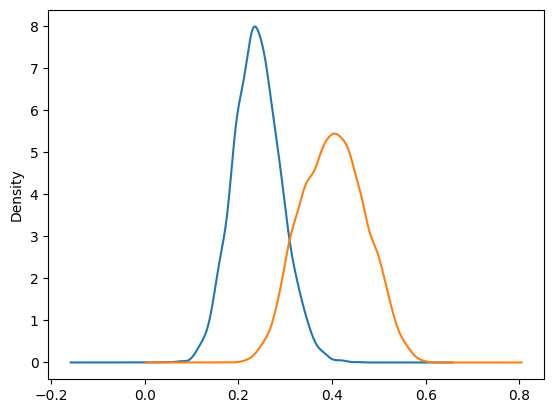

In [39]:
# KDE
df[df.decision == "Yes"].distance.plot.kde()
df[df.decision == "No"].distance.plot.kde()

In [40]:
p_mean = round(df[df.decision == "Yes"].distance.mean(), 4)
p_std = round(df[df.decision == "Yes"].distance.std(), 4)
n_mean = round(df[df.decision == "No"].distance.mean(), 4)
n_std = round(df[df.decision == "No"].distance.std(), 4)
print(p_mean, p_std)
print(n_mean, n_std)

0.2401 0.0508
0.4022 0.0675


In [41]:
sigma = 1 # 1, 2,..
threshold = round(p_mean + sigma * p_std, 4)
print(threshold)

0.2909


In [42]:
df['prediction'] = 'No'
idx = df[df.distance <= threshold].index
df.loc[idx, 'prediction'] = 'Yes'
df.head()

,file_x,file_y,decision,distance,prediction
0,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes,0.2228,Yes
1,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes,0.1547,Yes
2,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes,0.1811,Yes
3,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes,0.2388,Yes
4,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,/opt/ml/project/data/celeb/cut_test/cut_Hajung...,Yes,0.2065,Yes


In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df.decision.values, df.prediction.values)
print(cm)
tn, fp, fn, tp = cm.ravel()
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)
print('acc    : ', accuracy)
print('recall : ', recall)
print('f1     : ', f1)
print('precision : ', precision)

[[9454  446]
 [ 702 3798]]
acc    :  0.9202777777777778
recall :  0.844
f1     :  0.8687099725526075
precision :  0.8949104618284637


In [44]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print('Running on device: {}'.format(device))

In [45]:
def img_loader(path) :
    try : 
        with open(path, 'rb') as f :
            img = cv2.imread(path) 
            if len(img.shape) == 2 :
                img = np.stack([img] * 3, 2)
        
            return img
    except IOError :
        print('Cannot load image' + path)

In [46]:
def img2embedding(image_path, tranform=None) :
    img = img_loader(image_path)

    if transforms is not None :
        img = transform(img)
    else :
        img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    # print(img.shape)
    embedding = get_embedding(img)
    return embedding

In [47]:
def calculate(rank_list, train_label) :
    count = 0
    for dis, label in rank_list :
        if label == train_label :
            count += 1
    return count

In [48]:
def get_embedding_from_file(FILEPATH) :
    model.eval()
    with torch.no_grad() :
        dataset = Crawling_Nomal_Dataset(FILEPATH, transforms=transform)
        data_loader = data.DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=2, drop_last=False)
        
        for feature, path_label_list in data_loader :
            embeddings = get_embedding(feature)
            print(len(path_label_list[1]))
            print(path_label_list[1])
            print(embeddings.shape)
            return embeddings, path_label_list

In [49]:
# train_path

In [50]:
# for x in os.listdir(train_path):
#     a =x.split('.')[-1]
#     if a!='jpg':
#         xx = x.split('.')[:-1]
#         rename = xx[0] +'.jpg'
#         old_path = os.path.join(train_path,x)
#         new_path = os.path.join(train_path,rename)
#         os.rename(old_path,new_path)

In [51]:
# train_embeddings, path_label_list = get_embedding_from_file(train_path)


In [54]:
test_embeddings, path_label_list = get_embedding_from_file(test_path)


/opt/conda/envs/deepface/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1000
tensor([73, 80,  1,  5, 79, 64, 76, 29, 10, 23, 80, 22,  7, 28, 72, 98, 23, 98,
        95, 73, 36, 28, 68, 73, 49, 99, 56, 89, 91, 68, 21,  5, 61,  5, 90, 21,
        38, 52, 25, 76, 16, 51, 55, 28, 58,  3, 44, 21, 42, 63, 23, 33, 89, 38,
        27, 68,  4, 84,  0, 69, 59, 56, 88, 82, 34, 26, 22, 18, 84, 48,  9, 59,
        16, 67, 40, 83, 76, 36, 12,  2,  9, 92, 82, 93, 43, 97, 72, 22, 28, 57,
        95, 12, 77, 33, 36, 87, 20, 91, 89, 61, 52, 89, 63, 86, 66, 33, 29, 45,
        22, 93, 65, 73, 20, 24, 30, 98, 39, 40, 81, 94, 12, 28, 24, 29,  1, 73,
        24, 75, 33, 28, 52, 59, 84, 83, 98, 41, 26, 93, 97, 32, 53, 91, 64, 48,
         0, 72, 10, 22, 65, 38, 36, 97, 90,  4, 84, 17,  5, 53, 40, 75, 43, 61,
        56, 81, 14, 35, 55, 30, 37, 47, 93, 92, 15, 59, 34, 89, 71, 74, 98, 80,
        94, 12, 81,  2, 88, 50, 86, 51, 20, 54, 70, 31, 20,  5, 97, 60, 30, 99,
        71, 44, 70, 18, 97, 34, 30, 15, 93, 42,  1, 19, 60, 45, 90, 91, 15, 87,
        27, 94, 27, 75, 73, 71,  2,

In [55]:
TOP_NUM = 10
eu_ten_check_list = []
correct_count_dict = defaultdict(lambda : 0)
model.eval()
with torch.no_grad():
    # for idx,(feature, b) in enumerate(tqdm.tqdm(train_embedding_loader, leave=True)) :
    for idx,(feature, b) in enumerate(tqdm.tqdm(train_data_loader, leave=True)) :
        train_embedding = get_embedding(feature)
        # print(train_label)
        train_label = b[1].tolist()[0]
        train_image_path = b[0][0]
        eu_label_embedding_list = []

        eu_dist = distance(train_embedding, test_embeddings, 1)
        test_label_list = path_label_list[1].tolist()
        
        for pair in zip(eu_dist, test_label_list) :
            eu_label_embedding_list.append(pair)

        eu_label_embedding_list = sorted(eu_label_embedding_list)
        eu_top_rank_list = eu_label_embedding_list[:TOP_NUM]
        
        count = calculate(eu_top_rank_list, train_label)
        correct_count_dict[train_label] += count
        if count < 7 :
            eu_ten_check_list.append((train_image_path,train_label))

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/envs/deepface/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/envs/deepface/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will ch

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/envs/deepface/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/envs/deepface/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/envs/deepface/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/ml/project/insightface/recognition/level3_cv_finalproject-cv-14/Crawling_Dataset.py", line 152, in __getitem__
    img = self.loader(image_path)
  File "/opt/ml/project/insightface/recognition/level3_cv_finalproject-cv-14/Crawling_Dataset.py", line 17, in img_loader
    if len(img.shape) == 2 :
AttributeError: 'NoneType' object has no attribute 'shape'


In [ ]:
NUM2NAME_dict = train_dataset.get_label_dict_NUM2NAME()
NAME2NUM_dict = train_dataset.get_label_dict_NAME2NUM()
print(NUM2NAME_dict)

{0: 'Songjihyo', 1: 'Jinsunkyu', 2: 'Iu', 3: 'Leekyunggyu', 4: 'Kimeungsoo', 5: 'Kimbumrong', 6: 'Jeonjihyeon', 7: 'Chunwoohee', 8: 'Kimyoojung', 9: 'Wonbin', 10: 'Kimjongjin', 11: 'Jungkook', 12: 'Yoonyeojung', 13: 'Chaesira', 14: 'Hayumi', 15: 'Shinsekyung', 16: 'Jojeongseok', 17: 'Kimhyeseon', 18: 'Hansohee', 19: 'Kimsangjoong', 20: 'Meenoi', 21: 'Hangain', 22: 'Ongseogwu', 23: 'Limsoojung', 24: 'Choisoojong', 25: 'Jujihun', 26: 'Kwonhaehyo', 27: 'Shinyeeun', 28: 'Hanhyojoo', 29: 'Wonmikyung', 30: 'Leemangi', 31: 'Yeojingoo', 32: 'Choibulam', 33: 'Leedongwook', 34: 'Chahwayeon', 35: 'Kimsarang', 36: 'Kimgwanggyu', 37: 'Namkoongmin', 38: 'Ahnyoungmi', 39: 'Hanyeseul', 40: 'Yooyeonseok', 41: 'Leeseungki', 42: 'Yookseongjae', 43: 'Leemisuk', 44: 'Kangsuyeon', 45: 'Yimsiwan', 46: 'Parkjiseong', 47: 'Leegookju', 48: 'Jungboseok', 49: 'Choiran', 50: 'Namjoohyuk', 51: 'Sonyejin', 52: 'Hahuirah', 53: 'Choiminsik', 54: 'Parknarae', 55: 'Yoonyuseon', 56: 'Chungangleul', 57: 'Leehwihyang', 58:

<BarContainer object of 57 artists>

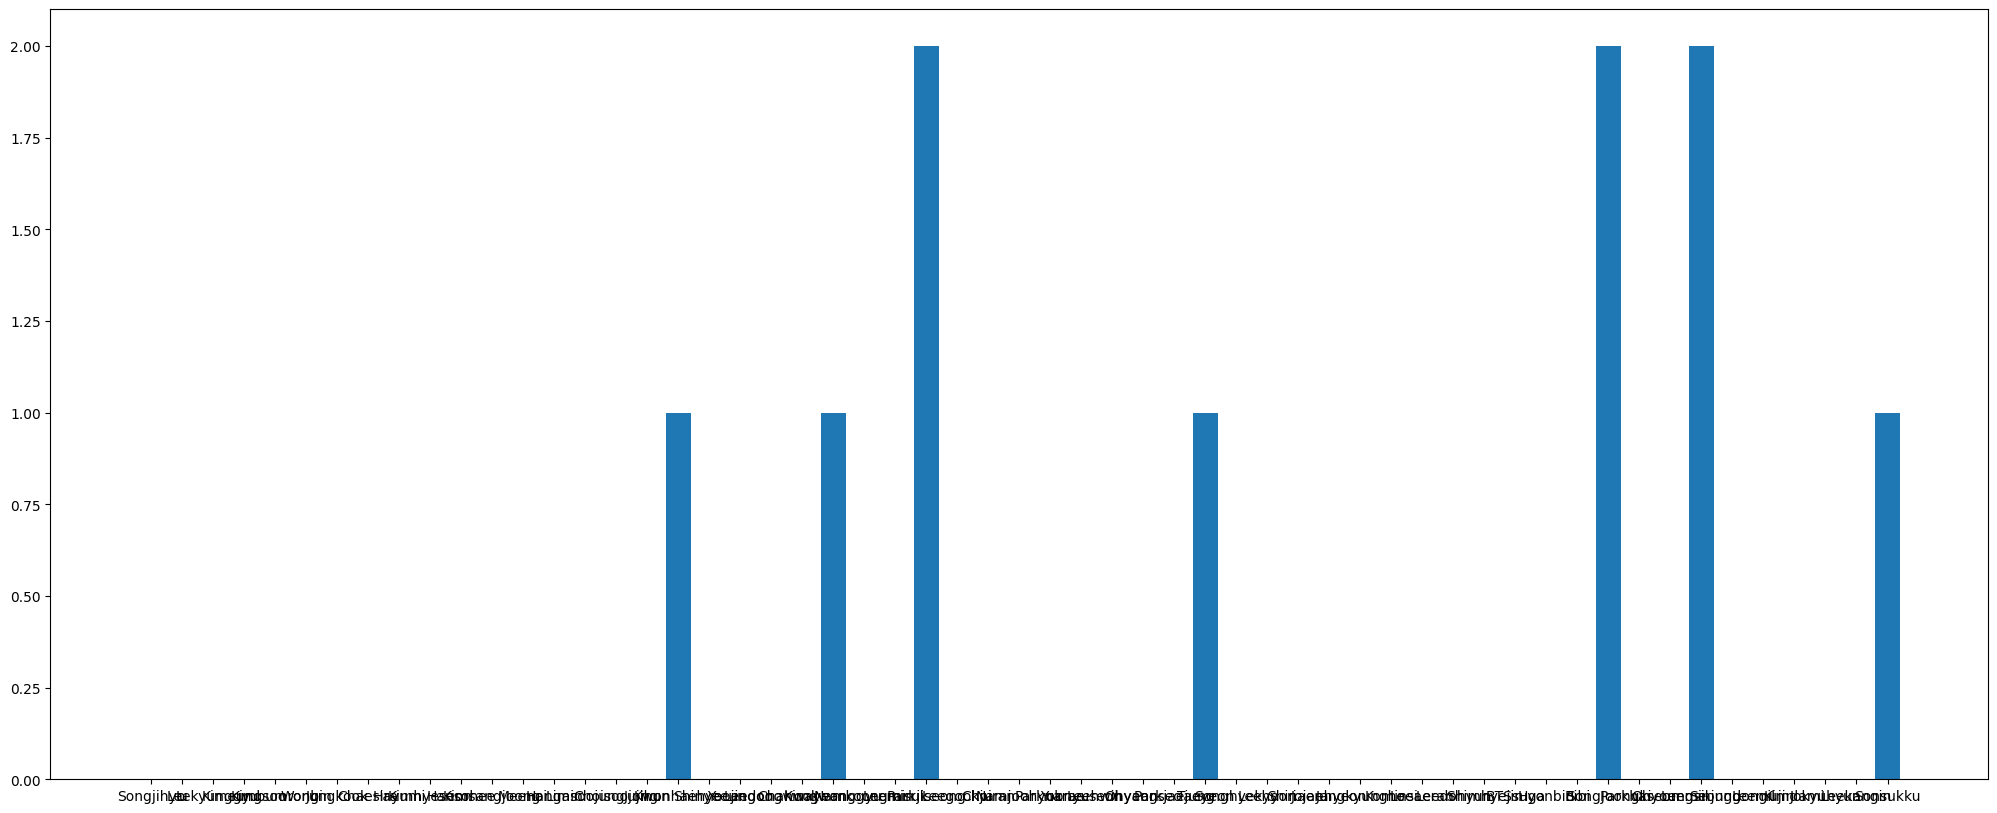

In [ ]:
item = correct_count_dict.items()
item = sorted(item)
name = []
counts = []
for label, count in item :
    name.append(NUM2NAME_dict[label])
    counts.append(count)
plt.figure(figsize=(25,10))
plt.bar(name, counts)